## 2nd iteration of my own sheet

Creating my own version of the dogs_cats_redux notebook in order to make my own entry into the Kaggle competition.

See 1st sheet for setup info

In [1]:
#Verify we are in the lesson1 directory
%pwd

u'/home/rallen/Documents/PracticalDL4C/kaggle/dogscats'

In [2]:
%matplotlib inline

In [8]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '../utils'))
from utils import *
#from vgg16 import Vgg16
#from vgg16bn import Vgg16BN
from PIL import Image
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix

In [9]:
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'

## Create validation set and sample
## Rearrange image files into their respective directories

did these in previous notebook, no longer

## Finetuning and Training

OKAY, ITERATE HERE

In [6]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/rallen/Documents/PracticalDL4C/kaggle/dogscats/data


In [10]:
vgg = Vgg16BN()

/home/rallen/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [11]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=1

In [12]:
# NEW! Augment the data
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [13]:
#Finetune the model
# NEW, just add gen as 2nd parameter to batches
batches = vgg.get_batches(train_path, gen, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [14]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None

#latest_weights_filename='gt36.h5'
#vgg.model.load_weights(results_path+latest_weights_filename)

if you are training, stay here.  if you are loading & creating submission skip down from here.

In [15]:
# if you have run some epochs already...
# let's try reducing this & give it another go
#vgg.model.optimizer.lr = 0.001
epoch_offset=0
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % (epoch + epoch_offset)
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'nbgt%d.h5' % (epoch + epoch_offset)
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 257s - loss: 0.6104 - acc: 0.9519 - val_loss: 0.2130 - val_acc: 0.9835

```
Results of ft1.h5
0 val_loss: 0.2122 val_acc: 0.9830
1 val_loss: 0.1841 val_acc: 0.9855
[[987   7]
 [ 20 986]]
--
2 val_loss: 0.2659 val_acc: 0.9830
3 val_loss: 0.2254 val_acc: 0.9850
4 val_loss: 0.2072 val_acc: 0.9845
[[975  19]
 [ 11 995]]
 
Results of first0.h5
0 val_loss: 0.2425 val_acc: 0.9830
[[987   7]
 [ 27 979]]
 
ft35 with augmented images
0 val_loss: 0.3139 - val_acc: 0.9805
[[ 959   35]
 [   4 1002]]
+ 0.001 lr
0 val_loss: 0.2530 - val_acc: 0.9830
[[ 966   28]
 [   6 1000]]
+2 iters
0 val_loss: 0.2221 - val_acc: 0.9860
1 val_loss: 0.2626 - val_acc: 0.9830
[[973  21]
 [  8 998]]

```

In [ ]:
# only if you have to
latest_weights_filename='ft1.h5'
vgg.model.load_weights(results_path+latest_weights_filename)

## Validate Predictions

In [33]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

Found 2000 images belonging to 2 classes.


[[973  21]
 [  8 998]]


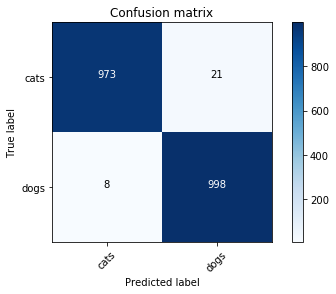

In [34]:
cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

In [ ]:
#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

In [ ]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

In [ ]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

In [ ]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

In [ ]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

In [ ]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

In [ ]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

In [ ]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

## Generate Predictions

In [35]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)
# Error allocating 3347316736 bytes of device memory (out of memory).
# got this error when batch-size = 128
# I see this pop up to 6GB memory with batch_size = 64 & this takes some time...

Found 12500 images belonging to 1 classes.


In [11]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]
['unknown/2850.jpg', 'unknown/8158.jpg', 'unknown/4719.jpg', 'unknown/4743.jpg', 'unknown/11184.jpg']


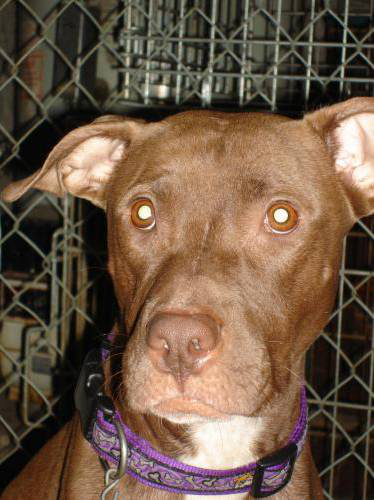

In [12]:
#You can verify the column ordering by viewing some images
Image.open(test_path + filenames[1])

In [ ]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Submit Predictions to Kaggle!

In [36]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [37]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

Raw Predictions: [ 0.  1.  0.  1.  0.]
Mid Predictions: [ 0.5957  0.4018  0.5726  0.4567]
Edge Predictions: [ 0.  1.  0. ...,  0.  0.  0.]


In [38]:
#play it safe, round down our edge predictions
#isdog = isdog.clip(min=0.05, max=0.95)
#isdog = isdog.clip(min=0.02, max=0.98)
isdog = isdog.clip(min=0.01, max=0.99)

In [39]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [40]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  2.8500e+03,   1.0000e-02],
       [  8.1580e+03,   9.9000e-01],
       [  4.7190e+03,   1.0000e-02],
       [  4.7430e+03,   9.9000e-01],
       [  1.1184e+04,   1.0000e-02]])

In [41]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission5.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/rallen/Documents/PracticalDL4C/kaggle/dogscats/data


In [42]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/'+submission_file_name)

/home/rallen/Documents/PracticalDL4C/kaggle/dogscats


/home/rallen/Documents/PracticalDL4C/kaggle/dogscats/data/submission5.csv